## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSSS'
meas='TOBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1473
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|  total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+-----------+------+--------------------+------+
|-868.7380179718102|-78.69031007408877|-195.41058400871646|     54.9|BSBSSSSS| 31.5339| -84.1489|       TOBS|0.5386753430129746|0.5268297410987876|0.5177698319334042| 0.1367539942549411|U

In [6]:
#extract longitude and latitude for each station
feature1='coeff_1'
feature2='coeff_2'
feature3='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,"+feature1+","+feature2+","+feature3+" FROM weather"
print(Query)
df1 = sqlContext.sql(Query)
df1.show()

SELECT station, latitude,longitude,elevation,coeff_1,coeff_2,coeff_3 FROM weather
+-----------+--------+---------+---------+------------------+-------------------+-------------------+
|    station|latitude|longitude|elevation|           coeff_1|            coeff_2|            coeff_3|
+-----------+--------+---------+---------+------------------+-------------------+-------------------+
|USC00090140| 31.5339| -84.1489|     54.9|-868.7380179718102| -78.69031007408877|-195.41058400871646|
|USC00098703| 31.4461| -83.4767|    115.8| -775.356752843772| -39.87231458249827| -63.22221211478987|
|USC00096087| 31.1769| -83.7492|    103.6| 772.3457150926299|-113.41920268503587|  87.52778502109916|
|USC00096087| 31.1769| -83.7492|    103.6| 793.2314050286112|-117.32663636156519|  50.07181029448829|
|USC00013761| 31.3625| -85.3397|    112.8|-696.6960516591587|-230.18523570538315| -249.4818385656602|
|USC00093578|  31.615| -85.0494|     64.0|-845.6739032997987|  67.24721417081354| -76.99052771547179|


In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature1: "mean", feature2: "mean", feature3: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(1000)

,station,latitude,longitude,elevation,count(station),avg(coeff_1),avg(coeff_2),avg(coeff_3)
26,USC00013761,31.3625,-85.3397,112.8,54,-750.947021,-45.871844,35.232521
6,USC00014895,31.1000,-85.1667,-999.9,5,627.325120,66.582424,-82.708658
35,USC00080025,29.8833,-83.6333,-999.9,1,363.486042,415.894004,311.106765
25,USC00080804,30.4500,-85.0500,18.3,57,-502.835386,11.772710,22.922056
36,USC00081020,30.4181,-84.9861,48.8,3,254.745078,-13.972476,-89.442343
4,USC00081022,30.3794,-84.9789,43.9,10,-916.016865,29.616102,23.192972
16,USC00081356,29.8667,-84.6667,3.0,62,293.410209,10.398220,-23.207485
2,USC00081544,30.7836,-85.4847,39.6,64,-145.521310,31.708781,-44.889556
19,USC00081601,30.4647,-85.1992,38.1,4,-910.743195,89.437733,-44.395596
24,USC00081775,30.6000,-85.4000,64.0,24,579.323636,82.918815,-36.964019


In [10]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature1
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [11]:
min_lat,max_lat,min_long,max_long = box = (29, 32, -86, -83)


In [12]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

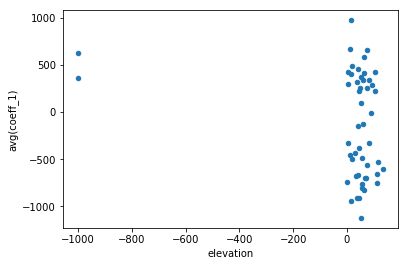

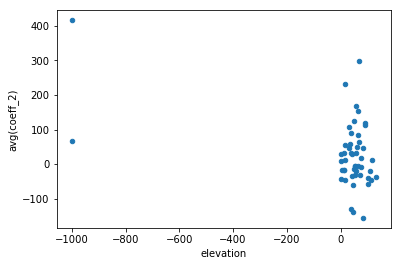

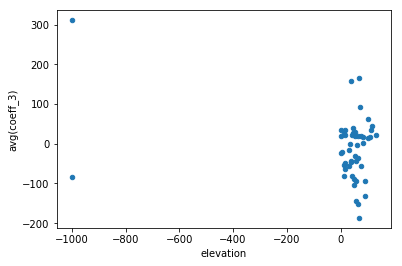

In [11]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');
pdf.plot.scatter(x='elevation',y='avg(coeff_2)');
pdf.plot.scatter(x='elevation',y='avg(coeff_3)');

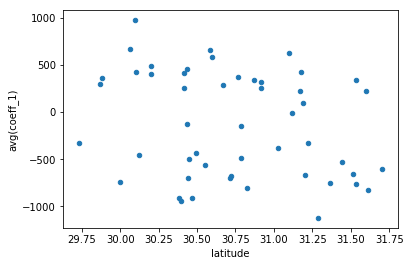

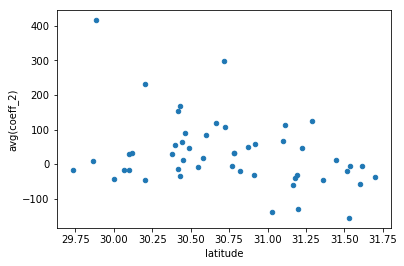

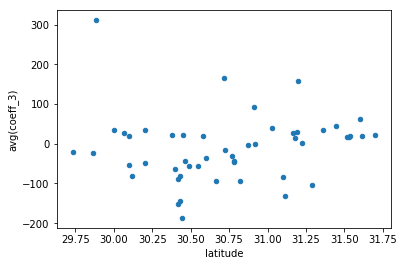

In [12]:
%matplotlib inline
pdf.plot.scatter(x='latitude',y='avg(coeff_1)');
pdf.plot.scatter(x='latitude',y='avg(coeff_2)');
pdf.plot.scatter(x='latitude',y='avg(coeff_3)');

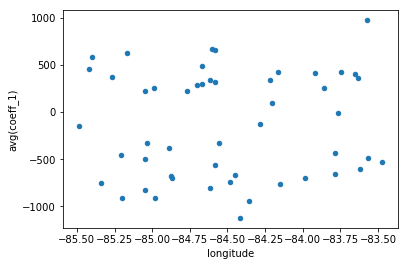

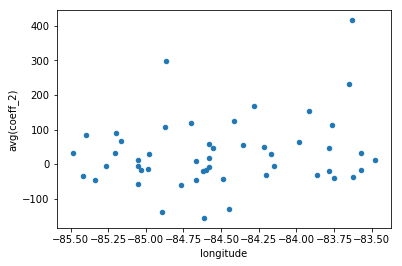

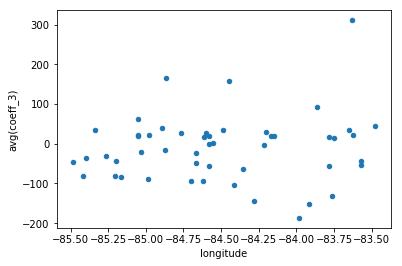

In [13]:
%matplotlib inline
pdf.plot.scatter(x='longitude',y='avg(coeff_1)');
pdf.plot.scatter(x='longitude',y='avg(coeff_2)');
pdf.plot.scatter(x='longitude',y='avg(coeff_3)');

In [14]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']